In [1]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
import numpy as np
import collections
from collections import Counter
import math
import random

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

/home/jharmse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Objective

Predict the score of a wine review based purely on the textual features of the review.

## General Strategy

Use Word Embeddings and LSTM to extract as much semantical value from the reviews, with the hypothesis that semantically positive reviews will have higher ratings that semantically negative reviews.

## Data Import

The data used for this analysis can be found [here](https://www.kaggle.com/zynicide/wine-reviews).

Two datasets are included, which have been scraped at different points in time.

The unique reviews from both datasets will be used.

All columns will be dropped, excepts for the `description` (independent variables) and `points` (dependent variable).

In [2]:
# columns to use
cols=['description', 'points']

# import data
reviews_1 = pd.read_csv('../../data/wine-reviews/winemag-data_first150k.csv', index_col=False, usecols=cols)
reviews_2 = pd.read_csv('../../data/wine-reviews/winemag-data-130k-v2.csv', index_col=False, usecols=cols)

print("Number of entries in dataset 1: %s" %reviews_1.shape[0])
print("Number of entries in dataset 2: %s" %reviews_2.shape[0])

duplicates = set(reviews_1.description).intersection(set(reviews_2.description))

print("\nNumber of duplicate entries across datasets: %s" % len(duplicates))

# concatenate and drop duplicates
data = pd.concat([reviews_1,reviews_2]).drop_duplicates().reset_index(drop=True)
data.drop_duplicates(inplace=True)

print("\nNumber of unique reviews: %s" % data.shape[0])

data.head()

Number of entries in dataset 1: 150930
Number of entries in dataset 2: 129971

Number of duplicate entries across datasets: 48346

Number of unique reviews: 169461


,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


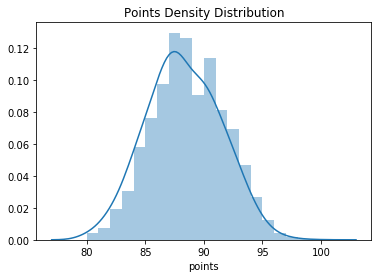

In [3]:
sns.distplot(data.points,  bins = range(data.points.min(), data.points.max() + 1), 
             kde_kws={'bw':1}).set_title("Points Density Distribution")
plt.show()

## Data Cleaning

The following text cleaning tasks are performed:

* Change to lower case (make words more generic)

* Remove punctuation (isn't of any importance in this scenario)

* Replace `%` with `percent` (it seems with wine reviews, percentage is a common word, so we keep it)

* Replace `_` with whitespace (a few of these have been observed)

* Tokenize words (Reviews contain quite a bit of slang. Good to generalise)

* Remove stop words (We are only interested in the semantically important words to determine review scores. Stop words can be excluded)

* Stem words (Use word stemming to generalise words. If words are too unique, it won't add value)

* Split review by words (need to do this for word embedding) 

In [4]:
def text_cleaning(data):
    """Clean text data using the following techniques:
        - remove punctuation
        - replace percentage sign
        - replace unique characters with more sensible characters
        - tokenize words
        - remove stopwords
        - use word stemming
    """
    # punctuation to remove
    punc_remove = string.punctuation
    punc_remove = punc_remove.replace('%', '')

    # stopwords to remove
    stop_words = stopwords.words('english')

    # lowercase
    data['description'] = data.description.str.lower()
    # remove punctuation
    data['description'] = data.description.str.replace('[' + punc_remove + ']', '')
    # replace percentage sign
    data['description'] = data.description.str.replace('%', ' percent')
    # replace underscores
    data['description'] = data.description.str.replace('_', ' ')
    # tokenize
    data['description'] = data['description'].apply(word_tokenize)
    # remove stop words
    data['description'] = data['description'].apply(lambda x: [word for word in x if word not in stop_words])
    # word stemming
    porter = PorterStemmer()
    data['description'] = data['description'].apply(lambda x: [porter.stem(word) for word in x])
    
    return data

data = text_cleaning(data)

data.head()

,description,points
0,"[tremend, 100, percent, variet, wine, hail, oa...",96
1,"[ripe, aroma, fig, blackberri, cassi, soften, ...",96
2,"[mac, watson, honor, memori, wine, made, mothe...",96
3,"[spent, 20, month, 30, percent, new, french, o...",96
4,"[top, wine, la, bégude, name, highest, point, ...",95


## Word Embedding

We will be using **Word2Vec** with **skip-gram** to create vectors for the words that occur most frequently in the reviews.

First we determine our complete vocabulary - all the unique words occurring in the reviews. We also capture the number of occurances for each word so that we can differentiate between frequently used words and words that won't add much value.

In [5]:
def create_vocabulary(documents):
    """Unique words and counts"""
    vocabulary = Counter()

    for row in documents:
        vocabulary.update(row)
        
    return vocabulary

documents = list(data.description)
vocabulary = create_vocabulary(documents)
vocabulary_size = len(vocabulary)

print("Number of unique words: %s" % vocabulary_size)
n_words_common = len([x for x in list(vocabulary.values()) if x > 10])
print("Number of words occurring more than 10 times: %s" % n_words_common)

Number of unique words: 45426
Number of words occurring more than 10 times: 8184


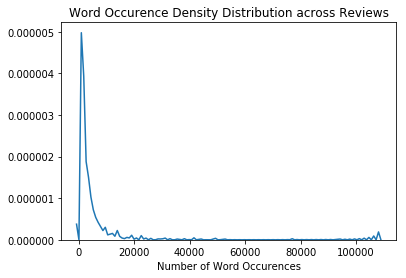

In [6]:
sns.distplot(list(vocabulary.values()), kde_kws={'bw':250}, hist=False, 
            axlabel = 'Number of Word Occurences').set_title("Word Occurence Density Distribution across Reviews")
plt.show()

In [7]:
print("Top 10 most common stem words (excludes stop words):")
pd.DataFrame(vocabulary.most_common(10), columns=['word', 'count'])

Top 10 most common stem words (excludes stop words):


,word,count
0,wine,108187
1,flavor,93686
2,fruit,76736
3,finish,52391
4,aroma,49137
5,acid,48837
6,palat,43873
7,cherri,41712
8,tannin,41276
9,drink,37941


In [8]:
percentile = 80
percentile_value = np.percentile(list(vocabulary.values()), percentile)
print("Number of word occurences at %d percentile: %d" % (percentile, percentile_value))

Number of word occurences at 80 percentile: 8


Looking at the density distribution of word occurrences above, it is evident that the majority of words occur rarely across reviews. We will only work with the 20% most common words. Words need to occur at least 8 times across all reviews to receive it's own word embedding. Otherwise it gets a default word embedding (grouping of all uncommon words). This is something that can be optimised.

So let's identify the 20% of words that occur most frequently. These words will receive their own word embeddings. The other words will be grouped together.

We also need to create integer IDs for each of these common words. The uncommon words will share the same ID. The integer IDs will be used within our neural network when embedding the words.

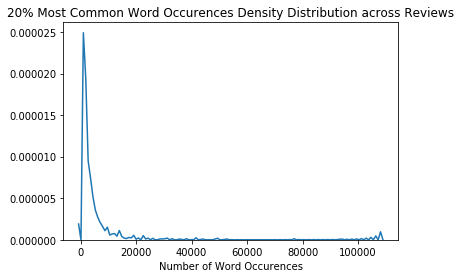

In [9]:
sns.distplot([x for x in vocabulary.values() if x > percentile_value], 
             kde_kws={'bw':250}, 
             hist=False, 
             axlabel = 'Number of Word Occurences').set_title("20% Most Common Word Occurences Density Distribution across Reviews")
plt.show()

In [10]:
def top_vocabulary(vocabulary, n_words):
    """Limit vocabulary to highest occurring words and create IDs."""
    vocabulary_n = list(dict(vocabulary.most_common(n_words - 1)).keys())
    vocabulary_n.append('UNK') # placeholder for rare words
    
    vocabulary_n = dict(zip(vocabulary_n, random.sample(range(0, n_words+1), n_words)))
            
    return vocabulary_n

In [11]:
n_top_words = int(0.2*len(vocabulary))
vocabulary_n = top_vocabulary(vocabulary, n_words = n_top_words)

Below follows an intermediate step for mapping the IDs to our vocabulary. We need to map the uncommon ID to each uncommon word (less than our word occurance percentile value).

In [12]:
def map_vocabulary(vocabulary, map_table):
    """Map vocabulary words to IDs"""
    vocabulary_map_table = dict.fromkeys(vocabulary.keys(), 0)
    for word in vocabulary:
        if word not in map_table:
            vocabulary_map_table[word] = map_table['UNK']
        else:
            vocabulary_map_table[word] = map_table[word]
            
    return vocabulary_map_table

In [13]:
vocabulary_map_table = map_vocabulary(vocabulary, vocabulary_n)

Now we can map each word in each review to an ID. This means we can represent our reviews in terms of integers.

In [14]:
def map_documents(documents, vocabulary_map_table):
    """Map documents to integer word IDs"""
    documents_mapped = [[vocabulary_map_table[word] for word in doc] for doc in documents]
    
    return documents_mapped        

In [15]:
documents_mapped = map_documents(documents, vocabulary_map_table) 

With Word2Vec we want to determine which words relate to each other given a number of latent features. The way we do that is by trying to show our model a *target* word and letting the model try to predict a *context* word. With skip-gram, the method we will be using, context words are words surrounding a target word within a review. We work under the assumption that words in close proximity of each other share context.

We need to feed in our context and target words as batches to our model.

We need to create context and target pairs, where the target word is the center word between the surrounding context words.

Below we ensure that context is only maintained within reviews (reviews are independent of each other).

We need to keep track of the batches going into our model, to prevent repeatedly training the model on the same review and completely missing other reviews.

First we initialize counters that will help keep track of which review, and where exactly in the review, did we stop with the previous batch creation.

In [16]:
# keep track of which review was last fed into the model
review_index = 0
# keep track of which word within review was last fed into the model
word_index = 0

In [17]:
# just out of interest
total_num_words = sum([len(doc) for doc in documents_mapped])
print("Total number of words in reviews: %d" % total_num_words)

Total number of words in reviews: 4246965


We systematically iterate through reviews as we generate batches. If we want to reach the end of the reviews and we want to generate more batches, the iterators will reset and start collecting words from the first review again.

The function will return both context and target which are needed for the skip grams architecture.

In [18]:
def generate_batch(documents_mapped, batch_size, num_skips, skip_window):
    
    global review_index
    global word_index
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # span considers window on both sides of target word
    # we could potentially consider a full sentence or review
    # as the context, but keeping it simpler for now
    span = 2 * skip_window + 1 
    
    # init buffer (context and target words)
    buffer = collections.deque(maxlen=span)
    
    # go back to first review if no more reviews left
    if review_index >= len(documents_mapped):
        review_index = 0
        word_index = 0
    
    # make sure there are enough words for skip-gram
    # could consider moving to next review instead of recycling words
    if word_index + span > len(documents_mapped[review_index]):
        word_index = max(len(documents_mapped[review_index]) - span - 1, 0)
    
    # new skip-gram
    buffer.extend(documents_mapped[review_index][word_index:word_index + span])
        
    for i in range(batch_size // num_skips):
        # skip_window is the same as index of target word
        context_words = [w for w in range(span) if w != skip_window]
        # randomly select context word indices to use
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            # target word
            batch[i * num_skips + j] = buffer[skip_window]
            # context word
            labels[i * num_skips + j, 0] = buffer[context_word]
        
        # add next words / new review for skips
        if word_index + span >= len(documents_mapped[review_index]):
            # next review
            if review_index < len(documents_mapped):
                review_index += 1
            # start at the beginning if non left
            else:
                review_index = 0
            
            word_index = 0
            buffer.extend(documents_mapped[review_index][word_index:word_index + span])
            word_index += span
        else:
            # add next word in review
            buffer.append(documents_mapped[review_index][word_index])
            word_index += 1
            
    return batch, labels

In [19]:
batch_size = 50
num_skips = 5
skip_window = 3
test_batch, test_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window) 

In [20]:
assert test_batch.shape[0] == batch_size

In [21]:
sample = pd.DataFrame({'Target_ID': test_batch[:15], 
              'Context_ID': [x[0] for x in test_labels[:15]]})

sample['Target_Word'] = sample['Target_ID'].apply(lambda x: 
                                                  list(vocabulary_map_table.keys())[list(vocabulary_map_table.values()).index(x)])
sample['Context_Word'] = sample['Context_ID'].apply(lambda x: 
                                                  list(vocabulary_map_table.keys())[list(vocabulary_map_table.values()).index(x)])

print('Sample of Target and Context Words and IDs:\n')
display(sample)

Sample of Target and Context Words and IDs:



,Target_ID,Context_ID,Target_Word,Context_Word
0,3326,8637,variet,hail
1,3326,4329,variet,tremend
2,3326,6305,variet,100
3,3326,6745,variet,wine
4,3326,8908,variet,oakvil
5,6745,8637,wine,hail
6,6745,4492,wine,percent
7,6745,3326,wine,variet
8,6745,4329,wine,tremend
9,6745,8908,wine,oakvil


There are a few parameters we need to specify for the model:

* **Embedding Size:** Dimensionality of each word vector (number of latent word features)

* **Batch Size:** Number of target-context pairs fed in to the model per batch. The mini-batches allows us to perform stochastic gradient descent to quickly and effectively find word embeddings.

* **Number of Skips:** Number of times a word should be used as the target word, when creating skip-grams.

* **Skip Window:** Size of window towards one side of the target word. The span width is $2*skip\ window\ + 1$. All words within the span width surrounding the target word, will be considered as context words.

* **Number of Negative Samples:** The number of negative examples (corrupt) context words to sample per batch. These corrupt samples will be used in the loss function (we want to be able to correctly identify a relevant context word and correctly identify a corrupt context word)

In [22]:
embedding_size = 512
batch_size = 50
num_skips = 5
skip_window = 3
num_sampled = 32

Below follows the Word2Vec graph.

We feed in a target word as input.

Then it in goes through the embeddings layer. These weight values are what we are interested in, and are the values we will use as our word vectors after training.

The word2vec graph as a single hidden layer.

The output of the hidden layer is fed into a logistic regression model to calculate the loss. It is computationally too expensive to use softmax, since the number of classes would be equal to our vocabulary.

In [23]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=batch_size) # target
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # context (what we want to predict)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    # hidden layer weights
    with tf.name_scope('weights'):
        nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                      stddev=1.0 / math.sqrt(embedding_size)))
    # hidden layers biases
    with tf.name_scope('biases'):
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
    # NCE because softmax is too expensive
    # is it a good or a corrupt pair (context and target)?
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights, 
                biases=nce_biases, 
                labels=train_labels, 
                inputs=embed, 
                num_sampled=num_sampled, 
                num_classes=vocabulary_size))
    
    # SGD - minimize loss on train data (see loss above)
    # Learning Rate = 1.0
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = tf.Variable(embeddings / norm)
    
    # init variables
    init = tf.global_variables_initializer()
    
    # save embeddings
    saver = tf.train.Saver({'word_embeddings': normalized_embeddings})

Now we can train our Word2Vec model.

In [24]:
num_steps = n_top_words # number of unique words

# keep track of which review was last fed into the model
review_index = 0
# keep track of which word within review was last fed into the model
word_index = 0

with tf.Session(graph=graph) as sess:
    
    sess.run(init)
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(documents_mapped, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
    
        _, loss_val = sess.run(
            [optimizer, 
             loss], 
            feed_dict=feed_dict)
        
        average_loss += loss_val
            
        if step % 500 == 0:
            if step > 0:
                average_loss /= 500
                
            print('Average loss at step', step, ': ', average_loss)

    save_path = saver.save(sess, 'word2vec/model.ckpt')

Initialized
Average loss at step 0 :  160.87515258789062
Average loss at step 500 :  103.27769944763183
Average loss at step 1000 :  74.96944637103272
Average loss at step 1500 :  60.379288578411014
Average loss at step 2000 :  55.03536309413986
Average loss at step 2500 :  48.31882251814232
Average loss at step 3000 :  42.123388917714664
Average loss at step 3500 :  39.11695111674363
Average loss at step 4000 :  35.01721163036192
Average loss at step 4500 :  32.28101387229446
Average loss at step 5000 :  30.814942225031196
Average loss at step 5500 :  28.77713695928298
Average loss at step 6000 :  27.361940510586198
Average loss at step 6500 :  25.157454449191718
Average loss at step 7000 :  23.2301262041097
Average loss at step 7500 :  22.414329832915495
Average loss at step 8000 :  22.0090171358707
Average loss at step 8500 :  19.001089430741814
Average loss at step 9000 :  18.935790353967533


The purpose of the word vectorization is to use the word vectors in our wine review score predictor model. We saved the word vectors locally, so that we can load it into our model. Since we are working in a notebook, saving and reloading the weights is a bit unnecessary, but in an production environment, for example, this will be necessary.

In [25]:
tf.reset_default_graph()

word_embeddings = tf.get_variable('word_embeddings', shape=[vocabulary_size, embedding_size])

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, 'word2vec/model.ckpt')
    word_embeddings = word_embeddings.eval()
    
print(word_embeddings)

INFO:tensorflow:Restoring parameters from word2vec/model.ckpt
[[ 0.01735813  0.0697111   0.0072919  ...  0.0455461  -0.04271783
   0.02080476]
 [-0.02731375  0.02893155  0.01642926 ...  0.039092    0.04627597
  -0.01325244]
 [ 0.003271   -0.04981974 -0.03103132 ... -0.05810078  0.01105965
   0.00627522]
 ...
 [ 0.01830723  0.02908921  0.06226132 ...  0.04861562 -0.05414085
  -0.06247323]
 [ 0.03084415  0.0490852  -0.05625423 ...  0.07009263  0.00126973
  -0.03924663]
 [-0.02000036  0.00726868 -0.02831908 ...  0.05911868  0.01569696
  -0.03957244]]


It's fun to visualize word embeddings. t-SNE can be used to reduce our word vectors to 2 principal components. This way we can get a sense of how our words relate to each other.

Bear in mind that word stemming have been applied to these words.

Also, we are only visualizing a handful of words to prevent clutter.

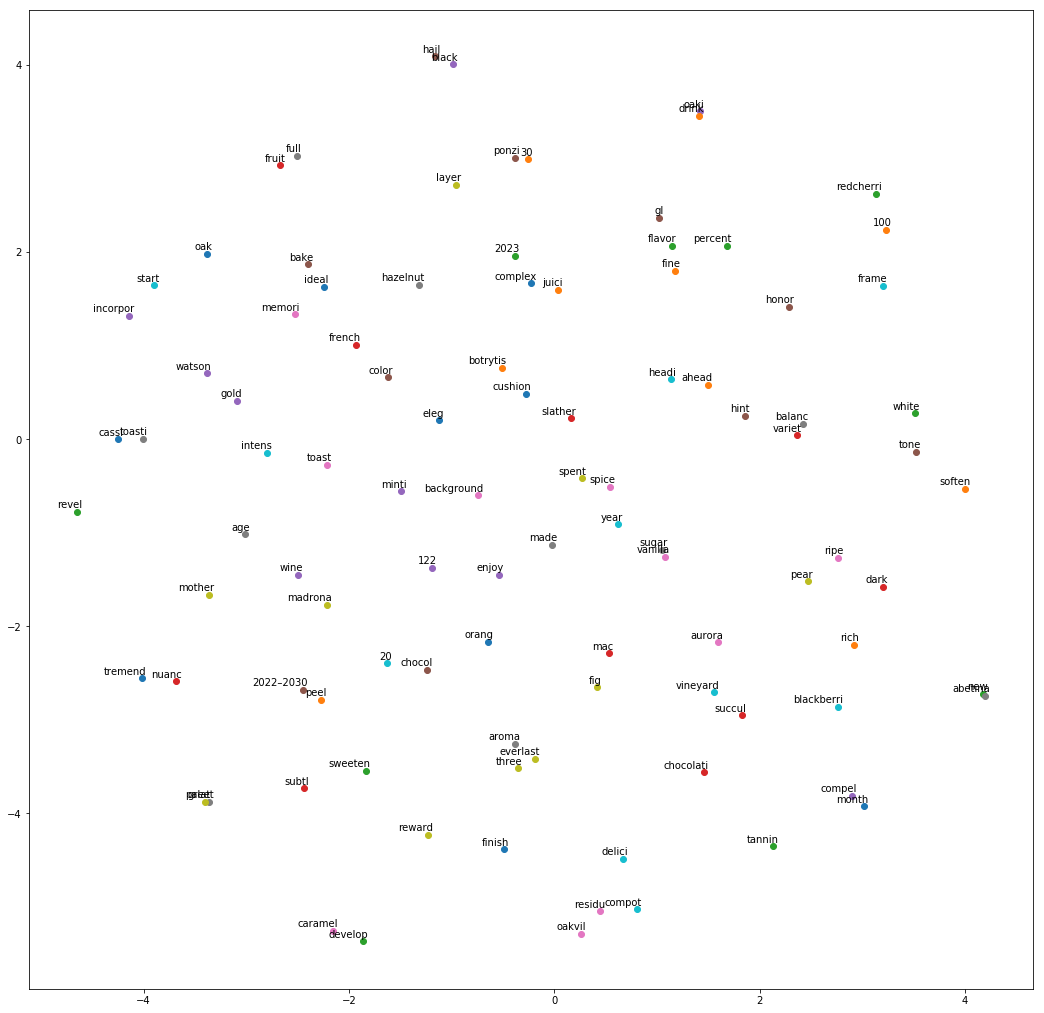

In [26]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 100
low_dim_embs = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [list(vocabulary_map_table.keys())[i] for i in range(plot_only)]

plt.figure(figsize=(18, 18))
for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

plt.show()

In [27]:
assert word_embeddings.shape[0] == len(vocabulary)

## LSTM

Now we can build our model that will predict the review score / points.

First we need to decide how long the sequences should be that are fed into our model.

After removing stop words, our reivews have shortened quite a bit in length.

In [28]:
print("Longest review has %d words (without stop words)" % data.description.apply(len).max())
print("On average review has %d words (without stop words)" % data.description.apply(len).mean())

# restrict review length
print("95 percent quantile review number of words (without stop words): %d" % data.description.apply(len).quantile(0.95))

Longest review has 83 words (without stop words)
On average review has 25 words (without stop words)
95 percent quantile review number of words (without stop words): 38


It seems reasonable to limit the input sequence length to 38 words per review. There aren't a lot of reviews with more words than this.

We will pad the reviews with zeros that do not have 38 words.

The reviews that have more than 38 words, we will cut off at 38 words.

In [29]:
max_review_length =  int(data.description.apply(len).quantile(0.95))

As with our word embeddings model, we need to feed in batches to our LSTM model.

Each sample within a batch will represent a review in terms of a sequence of words.

During training we want to feed in smallish batches and cycle through our reviews within our training data.

We are also creating a validation dataset. The test batch function helps us to get our validation set into the correct shape. However, we keep our validation dataset constant when comparing it to our training scores.

In [30]:
train_index = 0

def generate_train_batch(documents_mapped, output, batch_size):
    
    global train_index
    
    # pad with zeros if necessary
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        seq_len = min(len(documents_mapped[train_index]), max_review_length)
        batch[i, :seq_len] = documents_mapped[train_index][:seq_len]
        labels[i] = output[train_index]
        train_index += 1
        
        if train_index >= len(documents_mapped):
            train_index = 0
            
    return batch, labels


def generate_test_batch(documents_mapped, output):

    batch_size = len(output)
    
    batch = np.zeros(shape=(batch_size, max_review_length), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        seq_len = min(len(documents_mapped[i]), max_review_length)
        batch[i, :seq_len] = documents_mapped[i][:seq_len]
        labels[i] = output[i]
            
    return batch, labels

We need to split our reviews into two independent data subsets. One for training batches and one as a validation dataset.

In [31]:
documents_mapped_train, documents_mapped_validate, points_train, points_validate = train_test_split(
    documents_mapped, 
    data.points.values, 
    test_size=0.2, 
    random_state=1234)

Now we get our validation data into the correct shape.

In [32]:
validation_X, validation_y = generate_test_batch(documents_mapped_validate, points_validate)

There are a number of parameters we need to specify for our LSTM:

* Batch size: Size of batches using during training.

* Number of hidden units: Number of hidden LSTM units within an LSTM cell. These units remember the important long-term items in a sequence.

* Learning Rate: Controls the rate at which weights are adjusted. A high learning rate can prevent getting stuck in a local minima, while a low learning rate can prevent bouncing all over the place. This is an important parameter to tune.

In [33]:
batch_size = 24
h_units = 12
learning_rate = 0.05

Below follows our graph.

A review gets fed in in terms of word IDs as originally mapped out. Then it gets represented as word embeddings as determined with our Word2Vec model. These word vector values can be changed slightly, but the Word2Vec word embeddings help a lot with finding an appropriate starting position.

Then we enter the LSTM cell which tries to capture the overall feeling of the review.

We apply a small drop out for in case we have units that are resulting in model overfitting.

The last unit of the LSTM cell is then fed into a linear regression model (weights and biases) which attemps to map the review score/points function.

The output of the linear model is the predicted score of the review.

Mean squared error is used as our loss function, since this is a regression problem.

Stochastic Gradient Descent is used to optimize the model weights.

In [35]:
graph = tf.Graph()

with graph.as_default():
    
    # input data
    with tf.name_scope('inputs'):
        train_inputs = tf.placeholder(tf.int32, shape=[batch_size, max_review_length]) # review
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1]) # review points (predict)
        validation_inputs = tf.constant(validation_X)
        validation_labels = tf.constant(validation_y)
        
    with tf.name_scope('embeddings'):
        # embedding weights
        embeddings = tf.Variable(word_embeddings)
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
    
    with tf.name_scope('LSTM_1'):
        lstmCell = tf.nn.rnn_cell.LSTMCell(h_units)
        # drop out
        lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.9)
        # unroll
        value, _ = tf.nn.dynamic_rnn(lstmCell, embed, dtype=tf.float32)
    
    # output layer weights
    with tf.name_scope('weights'):
        output_weights = tf.Variable(tf.truncated_normal([h_units, 1],
                      stddev=1.0))
    # output layers biases
    with tf.name_scope('bias'):
        output_bias = tf.Variable(tf.zeros([1]))
        
    value = tf.transpose(value, [1, 0, 2])
    last = tf.gather(value, int(value.get_shape()[0]) - 1)
    
    predictions = tf.add(tf.matmul(last, output_weights), output_bias)
    
    # validation
    validation_embed = tf.nn.embedding_lookup(embeddings, validation_inputs)
    validation_value, _ = tf.nn.dynamic_rnn(lstmCell, 
                                               validation_embed, 
                                               dtype=tf.float32)
    validation_value = tf.transpose(validation_value, [1, 0, 2])
    validation_last = tf.gather(validation_value, int(validation_value.get_shape()[0]) - 1)
    validation_predictions = tf.add(tf.matmul(validation_last, output_weights), output_bias)
    
    # MSE since linear output
    with tf.name_scope('loss'):
        loss = tf.losses.mean_squared_error(
            labels=train_labels, 
            predictions=predictions)
        
        validation_loss = tf.losses.mean_squared_error(
            labels=validation_labels, 
            predictions=validation_predictions)
    
    # SGD - minimize loss on train data (see loss above)
    with tf.name_scope('optimizer'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # init variables
    init = tf.global_variables_initializer()
    
    # saver
    saver = tf.train.Saver()

Now we can train our model.

We perform 2 epochs, which means we are using the training data twice. This is another parameter that can be tuned. From the results in seems as if we might be able to increase the number of iteration steps even more.

Other parameters, such as learning rate, dimensionality of word embeddings, training batch size, number of hidden units all play a role in the accuracy of the model. These can be tuned given more time.

In [36]:
num_steps = 2 * len(points_train) // batch_size

tf.reset_default_graph()

with tf.Session(graph=graph) as sess:

    sess.run(init)
    print('Initialized')
    
    average_loss = 0
    
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_train_batch(documents_mapped_train, points_train, batch_size)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = sess.run(
            [optimizer, loss], 
            feed_dict=feed_dict
        )
        
        average_loss += loss_val
            
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2001
                
                print('Training loss at step', step, ': ', average_loss)
                print('Validation loss at step', step, ': ', validation_loss.eval())

                average_loss = 0

    save_path = saver.save(sess, 'lstm/model.ckpt')

Initialized
Training loss at step 2000 :  30.45003118376801
Validation loss at step 2000 :  10.472316
Training loss at step 4000 :  10.341199904188759
Validation loss at step 4000 :  10.039388
Training loss at step 6000 :  10.035218977439648
Validation loss at step 6000 :  9.698964
Training loss at step 8000 :  9.95903953404977
Validation loss at step 8000 :  10.202034
Training loss at step 10000 :  10.007007027077472
Validation loss at step 10000 :  9.605611


In [37]:
print('Thus, on average validation wine review point prediction is out by %.2f' % 9.6**0.5)

Thus, on average validation wine review point prediction is out by 3.10


That will have to do for now :)